In [16]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.layers import Dense, Input, BatchNormalization, Activation, merge, Dropout
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd
import matplotlib.pyplot as plt
%matplotlib inline

DESIRED_ACCURACY = 0.999
IMG_SIZE = 224
NUM_CLASSES = 2

In [ ]:
train_generator.

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
            directory = '/Users/neikusc/data/dogs_cats/train/',
            target_size=(IMG_SIZE,IMG_SIZE),
            batch_size = 128,
            class_mode = 'binary'
        )

valid_datagen = ImageDataGenerator(rescale=1/255.)
valid_generator = valid_datagen.flow_from_directory(
            '/Users/neikusc/data/dogs_cats/valid/',  # This is the source directory for training images
            target_size=(IMG_SIZE,IMG_SIZE),         # All images will be resized to IMG_SIZE x IMG_SIZE
            batch_size=32,                           # Flow training images in batches of 32 using train_datagen generator
            class_mode='binary',                     # Since we use binary_crossentropy loss, we need binary labels
        )

Found 19985 images belonging to 2 classes.
Found 5015 images belonging to 2 classes.


ValueError: num must be 1 <= num <= 18, not 19

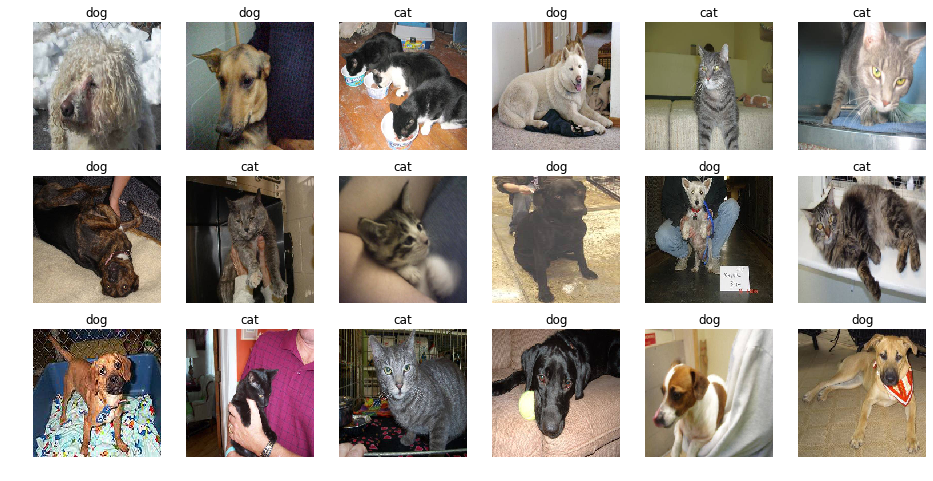

In [5]:
x, y = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

Weights: [ResNet50](https://github.com/fchollet/deep-learning-models/releases)  
References:  

1. [Image clustering using Transfer learning](https://towardsdatascience.com/image-clustering-using-transfer-learning-df5862779571)  
2. [Image Classification with Transfer Learning](https://github.com/hbhasin/Image-Recognition-with-Deep-Learning/blob/master/Image%20Classification%20with%20Transfer%20Learning.md)
3. [Boqiang Hu, Transfer-learning strategy to use ImageNet data](http://huboqiang.cn/2017/02/04/CatVsDog)

In [13]:
base_model = keras.applications.xception.Xception(include_top=False, 
                                                  weights='imagenet',
                                                  classes=NUM_CLASSES, 
                                                  input_shape=(IMG_SIZE,IMG_SIZE,3))
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', name='output')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
top_num = 2
model   = Model(input=base_model.input, output=x)

for layer in model.layers[:-top_num]:
    layer.trainable = False

for layer in model.layers[-top_num:]:
    layer.trainable = True

/Users/neikusc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`
  


In [19]:
from keras.callbacks import ModelCheckpoint

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
best_model = ModelCheckpoint("xception_best.h5", monitor='val_loss', verbose=0, save_best_only=True)

model.fit_generator(
        train_generator,
        samples_per_epoch=2048,
        nb_epoch=50,
        validation_data=valid_generator,
        nb_val_samples=1024,
        callbacks=[best_model])

Instructions for updating:
Use tf.cast instead.


/Users/neikusc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/Users/neikusc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=16, epochs=50, validation_steps=1024)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50
15/16 [===========================>..] - ETA: 1:16 - loss: 0.5763 - acc: 0.7417

In [ ]:
with open('xception.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
model.load_weights('xception_best.h5')
def get_image(index):
    img = cv2.imread('/Users/neikusc/data/dogs_cats/test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

test_num = 12500
image_matrix = np.zeros((test_num, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

predictions = model.predict(image_matrix, verbose=1)
s = 'id,label\n'
for i, p in enumerate(predictions):
    s += '%d,%f\n' % (i+1, p)

with open('KerasResultUsingXceptionNotop.csv', 'w') as f:
    f.write(s)

In [4]:
NUM_CLASSES = 2
PATH_TO_WEIGHTS = '/Users/neikusc/src/hackathon19/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = keras.applications.resnet50.ResNet50(weights=PATH_TO_WEIGHTS, 
                                             include_top=False, 
                                             classes=NUM_CLASSES, 
                                             input_shape=(IMG_SIZE,IMG_SIZE,3))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# Say not to train first layer (ResNet) model. It is already trained
model.layers[0].trainable = True

model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

model.summary()


checkpoint = ModelCheckpoint('model_resnet.h5', monitor='val_acc', verbose=0, 
                             save_best_only=True, save_weights_only=False, mode='auto')
# Train the model
history = model.fit_generator(train_generator, 
                              validation_data = valid_generator,
                              batch_size=256, 
                              epochs=30, 
                              verbose=1,
                              callbacks=[checkpoint])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
history = model.fit_generator(
                generator = train_generator,
                steps_per_epoch=2,  
                epochs=5,
                verbose=1,
                callbacks=[callbacks],
                validation_data = valid_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 366/1333 [=======>......................] - ETA: 20:49 - loss: 0.9317 - acc: 0.6091

In [ ]:
# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)

df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()